# Descriptive stats
This experiment describes the used datasets in terms of the evaluation as the uncontrolled ground truth.

In [4]:
import sys
sys.path.append(f'../source')
import data
import helpers
import importlib
#importlib.reload(helpers)
import evaluation
import models
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import random
from matplotlib import pyplot as plt
import pickle
import os
from dotenv import load_dotenv
load_dotenv()
random.seed(os.getenv("RANDOM_SEED"))

In [25]:
# params
out_file = '../data/corpus_classification.pkl'
max_responses = int(1e4)
n = 4
batch_size = 256

Load dialogs and list of classifiers

In [15]:
dialog_data = data.get_dialog_data()
random.shuffle(dialog_data)
dialog_data = dialog_data[0:max_responses]
classifiers_nrs = helpers.get_existing_classifiers("corpus_training")
egp = helpers.get_egp()

In [18]:
extracts = [[(dialog[0][i-n:i], dialog[0][i]) for i in range(n, len(dialog[0]))] for dialog in dialog_data]
extracts = helpers.flatten_list_of_lists(extracts)
sentences = [(idx, sentence) for idx, (context, response) in tqdm(enumerate(extracts), total=len(extracts)) for sentence in data.sent_tokenize(response)]

  0%|          | 0/85784 [00:00<?, ?it/s]

In [26]:
# initialize corpus to check against
sents = [s[1] for s in sentences]
indices = [s[0] for s in sentences]
change_indices = np.where(np.diff(indices))[0]

encoded_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)

In [28]:
corpus_dataloader = DataLoader(corpus_dataset, batch_size=512, shuffle=False)

In [29]:
dir="corpus_training"
all_hits = {}
all_scores = {}
for nr in classifiers_nrs:
    print(egp.iloc[nr-1]['Can-do statement'])
    classifier = models.load_classifier(nr, dir)
    classifier = DataParallel(classifier)
    scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=1e5, threshold=0.5)
    results = list(zip(scores, sents))
    hit_sentences = [sample for score, sample in results if score > 0.5]
    
    max_score_per_index = np.maximum.reduceat(scores, change_indices)
    hits = max_score_per_index > 0.5
    
    print("{:.2f}%".format(sum(hits)/len(hits)*100))
    all_hits[nr] = hit_sentences
    print(hit_sentences[0:10])
    all_scores[nr] = max_score_per_index

Can use the affirmative form with 'like'. 


  8%|███▏                                    | 23/289 [00:24<04:48,  1.08s/it]


KeyboardInterrupt: 

In [34]:
with open(out_file, 'wb') as f:
    pickle.dump(all_hits, f)
    pickle.dump(all_scores, f)

In [2]:
with open(out_file, 'rb') as f:
    all_hits = pickle.load(f)
    all_scores = pickle.load(f)

NameError: name 'pickle' is not defined

In [23]:
found_rules = np.array([set(egp.iloc[nr-1]['Can-do statement'] for nr, scores in all_scores.items() if scores[index] > 0.5) for index in range(len(change_indices))])
found_cats = [set(egp.iloc[nr-1]['SubCategory'] for nr, scores in all_scores.items() if scores[index] > 0.5) for index in range(len(change_indices))]
num_rules = np.array([len(rules) for rules in found_rules])
num_cats = np.array([len(cats) for cats in found_cats])

In [24]:
responses = np.array([e[1] for e in extracts])

In [25]:
list(zip(responses[np.where(num_cats>1)], found_rules[num_cats>1]))

[('If I wanted to hire 2 motorbikes tomorrow morning for 2 days, would there be any problem?',
  {"Can use 'not with indefinite pronouns 'everyone' and 'everything' and determiners 'every', 'all'.",
   "Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.",
   "Can use 'would' to talk about imagined situations.",
   "Can use negative pronoun 'none' to substitute for subject and object pronouns or noun phrases. ► pronouns: substitution",
   'Can use question forms.'}),
 ("Yes. It's crazy to think that people have been getting pedicures for more then 4000 years! ",
  {"Can use 'neither ... nor' to connect two words, phrases or clauses, often to give emphasis or focus.",
   "Can use 'never' in front position followed by an inverted subject (most commonly 'I') + main verb, to give focus. ",
   "Can use 'would have' + '-ed'.",
   "Can use 'would' to talk about imagined situations in the past. ► co

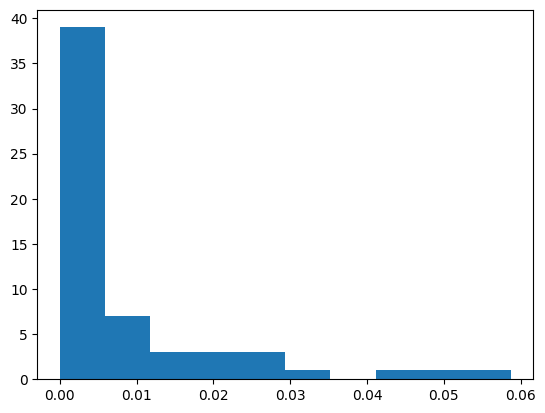

In [29]:
mean_scores = np.array([(np.array(score)>0.5).mean() for score in all_scores.values()])
plt.hist(mean_scores)
plt.show()

In [33]:
(mean_scores<0.001).sum()

13

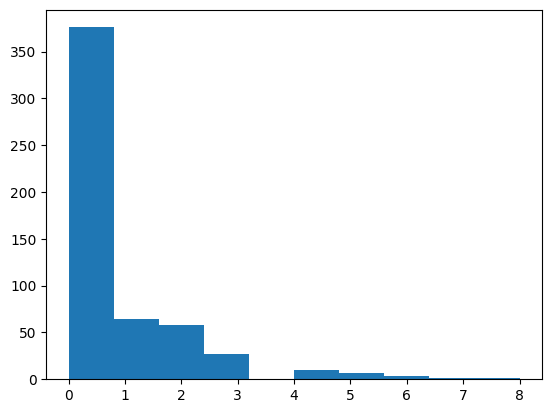

In [19]:
plt.hist(num_rules)
plt.show()

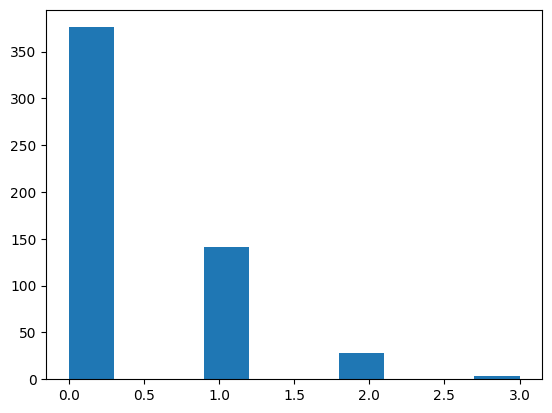

In [20]:
plt.hist(num_cats)
plt.show()